In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.neighbors import KNeighborsClassifier
from basketball_reference_scraper.players import get_stats

In [2]:
POSITION_TYPES = ['CENTER', 'GUARD', 'FORWARD']

# Centers
centers=[
    'nikola jokic',
    'joel embiid',
    'karl-anthony towns',
    'andre drummond',
    'bam adebayo'
]

# Guards
guards=[
    'damian lillard',
    'stephen curry',
    'luka doncic',
    'jamal murray',
    'james harden'
]

# Forwards
forwards=[
    'giannis antetokounmpo',
    'draymond green',
    'pascal siakam',
    'zion williamson',
    'blake griffin'
]


In [3]:
def fetch_player_career(player):
    career = get_stats(player, stat_type='PER_GAME', playoffs=False, career=False, ask_matches=False)
    
    # Drop rows containing 'Did Not Play' by only returning rows with digits in the "Games Played" field
    career_stats = career[career['G'].apply(lambda x: str(x).replace('.','').isdigit())]
    
    return career_stats

def extract_stats(career_stats):
    '''
    extract_stats() takes a player's stats and returns a numpy array of [PTS, AST, TRB, STL, BLK]
    '''
    total_seasons = len(career_stats)
    
    career_ppg = (sum(career_stats['PTS'].astype(float)) / total_seasons)
    career_ast = (sum(career_stats['AST'].astype(float)) / total_seasons)
    career_trb = (sum(career_stats['TRB'].astype(float)) / total_seasons)
    career_stl = (sum(career_stats['STL'].astype(float)) / total_seasons)
    career_blk = (sum(career_stats['BLK'].astype(float)) / total_seasons)
    
    return np.array([career_ppg, career_ast, career_trb, career_stl, career_blk])
    
def predict_position(stats, clf):    
    position_id = clf.predict(stats)[0]
    position = POSITION_TYPES[position_id]
    return position

In [4]:
careers = []
nba_players = centers + guards + forwards
for player in nba_players:
    print(player)
    careers.append(fetch_player_career(player))

nikola jokic
joel embiid
karl-anthony towns
andre drummond
bam adebayo
damian lillard
stephen curry
luka doncic
jamal murray
james harden
giannis antetokounmpo
draymond green
pascal siakam
zion williamson
blake griffin


In [5]:
X_train = np.zeros((15,5))
for i in range(len(careers)):
    X_train[i] = extract_stats(careers[i])
    
y_train = np.array([0]*5 + [1]*5 + [2]*5)

clf = KNeighborsClassifier()
clf.fit(X_train, y_train)

KNeighborsClassifier()

In [6]:
more_players = [
    'michael jordan', # 1
    'magic johnson',  # 1
    'chris paul',  # 1
    'dikembe mutombo',  # 0
    'russell westbrook',  # 1
    'larry bird',  # 2
    'john stockton',  # 1
    'derrick rose',  # 1
    'charles barkley',  # 2
    'demarcus cousins',  # 0
    'kyrie irving',  # 1
    'rudy gobert',  # 0
    'kawhi leonard',  # 2
    'devin booker',  # 1
    'steve nash',  # 1
    'tim duncan',  # 0
    'dirk nowitzki',  # 2
    'carmelo anthony',  # 2
    'paul george',  # 2
    'lebron james'  # 2
]

X_test = np.zeros((len(more_players),5))

for i in range(len(more_players)):
    all_career_stats = fetch_player_career(more_players[i])
    stats = extract_stats(all_career_stats).reshape(1,-1)
    X_test[i] = (stats)

y_test = [1, 1, 1, 0, 1, 2, 1, 1, 2, 0, 1, 0, 2, 1, 1, 0, 2, 2, 2, 2]

In [7]:
correct_pred = 0

for p in range(len(X_test)):
    predicted_position = predict_position(X_test[p].reshape(1,-1), clf)
    actual_position = POSITION_TYPES[y_test[p]]

    if predicted_position == actual_position:
        correct_pred += 1

    print(f'I think {more_players[p]} is a {predicted_position}. He played {actual_position} in his career')


I think michael jordan is a GUARD. He played GUARD in his career
I think magic johnson is a GUARD. He played GUARD in his career
I think chris paul is a GUARD. He played GUARD in his career
I think dikembe mutombo is a CENTER. He played CENTER in his career
I think russell westbrook is a GUARD. He played GUARD in his career
I think larry bird is a CENTER. He played FORWARD in his career
I think john stockton is a FORWARD. He played GUARD in his career
I think derrick rose is a CENTER. He played GUARD in his career
I think charles barkley is a CENTER. He played FORWARD in his career
I think demarcus cousins is a CENTER. He played CENTER in his career
I think kyrie irving is a GUARD. He played GUARD in his career
I think rudy gobert is a CENTER. He played CENTER in his career
I think kawhi leonard is a FORWARD. He played FORWARD in his career
I think devin booker is a GUARD. He played GUARD in his career
I think steve nash is a FORWARD. He played GUARD in his career
I think tim duncan is

In [8]:
print(f'{100*(correct_pred / len(y_test))}% accuracy')

70.0% accuracy


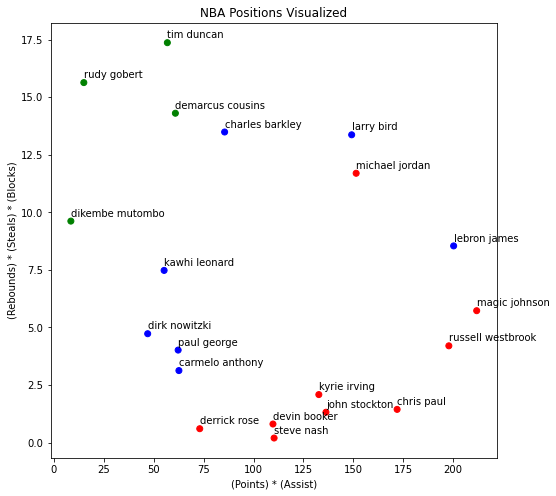

In [9]:
offensive_plays = np.array([X_test[:,0]*X_test[:,1]]).reshape(-1,1)  # points * assists
non_scoring_plays = np.array([X_test[:,2]*X_test[:,3]*X_test[:,4]]).reshape(-1,1)  # rebounds * blocks * steals
plot_2d = np.concatenate((offensive_plays, non_scoring_plays), axis=1)

# Constructing a dataframe for offensive_plays, non_scoring_plays, player, and position
df = pd.DataFrame(plot_2d, columns = ['offensive_plays','non_scoring_plays'])
df['player'] = more_players
df['position'] = [POSITION_TYPES[i] for i in y_test]

fig, ax = plt.subplots()

# Color-coded scatter plot for non_scoring_plays vs offensive_plays
colors = {'GUARD':'red', 'CENTER':'green', 'FORWARD':'blue'}
ax.scatter(df['offensive_plays'], df['non_scoring_plays'], c=df['position'].map(colors))
plt.gcf().set_size_inches((8, 8))

# Add players names to their plotted points
for i in range(len(df)):
    plt.annotate(df['player'][i], ((df['offensive_plays'][i], df['non_scoring_plays'][i]+.2)))

# Labeling title and axes and legend
plt.title("NBA Positions Visualized")
plt.xlabel("(Points) * (Assist)")
plt.ylabel("(Rebounds) * (Steals) * (Blocks)")
plt.show()